<a href="https://colab.research.google.com/github/carolsworld/DeepfakeDetector/blob/main/1_Dataset_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This is a notebook for creating the datasets for training, validation and testing for checking whether a video is a real video or deepfake video**

## Step 1 - In a new Google Colab notebook, turn on GPU in runtime

In [ ]:
# Check GPU information 
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

## Step 2 - Upload the video to Google Drive

Create several folders in Google Drive

Save the videos (.mp4) inside the following folders:

*   My Drive/DFD/data/DFDCpreview/trainSampleVideos/xxx.mp4
*   My Drive/DFD/data/CelebDFv2/Celeb-real/xxx.mp4
*   My Drive/DFD/data/CelebDFv2/Celeb-syn/xxx.mp4

Also create the following folders for backup the frames and chopped faces during image processing.

*   My Drive/DFD/data/DFDCpreview/frames/train
*   My Drive/DFD/data/CelebDFv2/frames/celereal
*   My Drive/DFD/data/CelebDFv2/frames/celesyn
*   My Drive/DFD/data/DFDCpreview/faces/train
*   My Drive/DFD/data/CelebDFv2/faces/celereal
*   My Drive/DFD/data/CelebDFv2/faces/celesyn

Note: Conversion from video to frames for DeepFakeDB is already processed into images of faces from the MesoNet (https://github.com/DariusAf/MesoNet). The steps for converting video to frames are mainly for Celeb-DF (v2) dataset and Deepfake Detection Challenge preview (DFDC preview) dataset. For DFDC preview, I only use training sample videos. I do not use the testing videos downloaded from Kaggle, as I do not know the label (fake / real) of the testing videos provided.

In [ ]:
# Confirm Google Drive is connected with Google Colab
google = !if [ -d 'GDrive/' ]; then echo "1" ; else echo "0"; fi
if (google[0] is '0' ):
  from google.colab import drive
  drive.mount('/content/GDrive/')
  
!if [ -d 'GDrive/' ]; then echo "Connection to Google drive successful" ; else echo "Error to connect to Google drive"; fi

Mounted at /content/GDrive/
Connection to Google drive successful


In [ ]:
# List the video files and model in Google drive which are to be transferred to a temporary directory in Google Colab
!ls GDrive/My\ Drive/DFD/data/DFDCpreview/trainSampleVideos
!ls GDrive/My\ Drive/DFD/data/CelebDFv2/Celeb-real
!ls GDrive/My\ Drive/DFD/data/CelebDFv2/Celeb-syn

In [ ]:
# Count the number of videos in the DFDC preview training sample videos dataset
!ls GDrive/My\ Drive/DFD/data/DFDCpreview/trainSampleVideos | wc -l

# Count the number of videos in the Celeb-DF (v2) dataset
!ls GDrive/My\ Drive/DFD/data/CelebDFv2/Celeb-real | wc -l
!ls GDrive/My\ Drive/DFD/data/CelebDFv2/Celeb-syn | wc -l

## Step 3 - Create a temporary directory in Google Colab. Copy the mp4 files and the model from your Google Drive to Google Colab

In [ ]:
# Set up environment and import libraries in Google Colab
!pip3 install --upgrade pip > /dev/null
!pip3 install scikit-image
!pip3 install opencv-python

In [ ]:
# Import libraries and modules in Google Colab
import cv2
from skimage.transform import resize
import matplotlib.pyplot as plt
import math
import os 

In [ ]:
not to use
# Make a temporarty directory in Google colab
!mkdir -p /content/DetectionTest/Sources/Real > /dev/null
!mkdir -p /content/DetectionTest/Sources/Fake > /dev/null
!mkdir -p /content/DetectionTest/Sources/frames/real > /dev/null
!mkdir -p /content/DetectionTest/Sources/frames/fake > /dev/null
!mkdir -p /content/DetectionTest/Sources/faces/real > /dev/null
!mkdir -p /content/DetectionTest/Sources/faces/fake > /dev/null
!mkdir -p /content/DetectionTest/Model > /dev/null

# copy video stored in Google Drive to Google Colab
!cp GDrive/My\ Drive/MyVideo/Real/*.mp4 DetectionTest/Sources/Real/
!cp GDrive/My\ Drive/MyVideo/Fake/*.mp4 DetectionTest/Sources/Fake/

# copy model stored in Google Drive to Google Colab
!cp GDrive/My\ Drive/MyModel/*.h5 DetectionTest/Model/

# List files Google Colab's temporary directory 
!ls /content/DetectionTest/Sources/Real
!ls /content/DetectionTest/Sources/Fake
!ls /content/DetectionTest/Model

In [ ]:
# Create temporarty directory in Google Colab
# Directory tree structure in Google drive
#      /DFD ──┐
#             └──────── /Sources ────────┐
#                                        ├─ videos (.mp4)
#                                        └─ /frames (.jpg)

!mkdir -p /content/DFD/Sources/frames > /dev/null

In [ ]:
# Copy mp4 videos stored in Google Drive to temporary directory in Google Colab
# Reminder - because of long processing time, select one of the folders for processing each time for avoid disconnection 
!cp GDrive/My\ Drive/DFD/data/DFDCpreview/trainSampleVideos/*.mp4 DFD/Sources/              # trainVideos with real and fake videos
!cp GDrive/My\ Drive/DFD/data/CelebDFv2/Celeb-real/*.mp4 DFD/Sources/                       # realVideo
!cp GDrive/My\ Drive/DFD/data/CelebDFv2/Celeb-syn/*.mp4 DFD/Sources/                        # fakeVideo

In [ ]:
# List files Google Colab's temporary directory 
!ls /content/DFD/Sources

In [ ]:
# Count number of files and folders in Google Colab's temporary directory for completeness check
!ls /content/DFD/Sources | wc -l

## Step 4 - Extract frames from the video

In [ ]:
# Folder path contains the videos
INPUT_VIDEOS_PATH = '/content/DFD/Sources'

# Folder path for storing image frames to be extracted from videos
OUTPUT_FRAMES_PATH = '/content/DFD/Sources/frames'

# Create variables
one_frame_each = 120                                                            # Para = 24, Extract 1 frame from a video for every 24 frames, around 1 second (DFDpreview)

!if [ -d {OUTPUT_FRAMES_PATH} ]; then echo "Output to be stored in "{OUTPUT_FRAMES_PATH} ; else mkdir {OUTPUT_FRAMES_PATH} && echo "Output directory created"; fi

videofiles = !ls {INPUT_VIDEOS_PATH}/*.mp4                                      # Video file names in INPUT VIDEOS PATH

In [ ]:
# Extract frames from videos 
for videofile in videofiles:
    count = 0
    success = True
    filename = os.path.basename(videofile)
    vidcap = cv2.VideoCapture(videofile)

    while success:
        if (count%one_frame_each == 0):                                             # checks frame number and keeps one_frame_each          
            success,image = vidcap.read()                                           # reads next frame           
            if image.shape[1]>640:                                                  # if image width > 640, resize it
                tmp = resize(image, (math.floor(640 / image.shape[1] * image.shape[0]), 640))
            plt.imsave("%s/%s%d.jpg" % (OUTPUT_FRAMES_PATH,filename,count), tmp, format='jpg') # saves images to frame folder
            print ('*', end="")
        else:
            success,image = vidcap.read()                                           # reads next frame
        count += 1                                                                  # loops counter

In [ ]:
# Count number of image frames in Google Colab's temporary directory 
!ls /content/DFD/Sources/frames | wc -l

In [ ]:
# Copy image frames stored in temporary directory to Google Drive
# Reminder - because of long processing time, select one of the folders for processing each time for avoid disconnection 
!cp DFD/Sources/frames/* GDrive/My\ Drive/DFD/data/DFDCpreview/frames/train
!cp DFD/Sources/frames/* GDrive/My\ Drive/DFD/data/CelebDFv2/frames/celereal
!cp DFD/Sources/frames/* GDrive/My\ Drive/DFD/data/CelebDFv2/frames/celesyn

In [ ]:
# Check to confirm all image frames stored in Google Drive
!ls GDrive/My\ Drive/DFD/data/DFDCpreview/frames/train | wc -l
!ls GDrive/My\ Drive/DFD/data/CelebDFv2/frames/celereal | wc -l
!ls GDrive/My\ Drive/DFD/data/CelebDFv2/frames/celesyn | wc -l

5200
5200
1681
35388


## Step 5 - Extract faces from the frames

Note: Conversion from frames to images of faces for DeepFakeDB is already made and downloaded from the MesoNet (https://github.com/DariusAf/MesoNet). The steps for converting frames to images of faces are mainly for Celeb-DF (v2) dataset and Deepfake Detection Challenge preview (DFDC preview) dataset. For DFDC preview, I only use training sample videos. I do not use the testing videos downloaded from Kaggle, as I do not know the label (fake / real) of the testing videos provided.

Because of long processing time, I have disconnected and reconnected to Google Colab and Google Drive after step 4. Temporary folder has to be created again in Google Colab. The frames are copied from the Google Drive to Google Colab for processing. Reconnect to Google Colab with GPU in the run time is required. 

In [ ]:
!apt-get install build-essential cmake
!apt-get install libopenblas-dev liblapack-dev
!pip install dlib
!pip install face_recognition
!pip install opencv-python
!pip install opencv-contrib-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
liblapack-dev is already the newest version (3.7.1-4ubuntu1).
libopenblas-dev is already the newest version (0.2.20+ds-4).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
     |████████████████████████████████| 100.1 MB 27 kB/s             
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=671044badcd32f5cdc0c31aede213bca77a82a03cf816ed95a651a98fe2926bd
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face

In [ ]:
# Create temporarty directory in Google Colab
# Directory tree structure in Google drive
#      /DFD ──┐
#             └───── /Sources ─────┐
#                                  ├─ images (.jpg)
#                                  └─ /Faces (.jpg)

!mkdir -p /content/DFD/Sources/Faces > /dev/null

In [ ]:
# Import OpenCV and face_recognition libraries to extract the faces from frames
from PIL import Image
import cv2
import face_recognition

In [ ]:
# Copy images stored in Google Drive to Colab
# Reminder - select one of the folders for processing 
!cp GDrive/My\ Drive/DFD/data/DFDCpreview/frames/train/*.jpg DFD/Sources/
!cp GDrive/My\ Drive/DFD/data/CelebDFv2/frames/celereal/*.jpg DFD/Sources/
!cp GDrive/My\ Drive/DFD/data/CelebDFv2/frames/celefake_tr/*.jpg DFD/Sources/
!cp GDrive/My\ Drive/DFD/data/CelebDFv2/frames/celefake_te/*.jpg DFD/Sources/

In [ ]:
# List files Google Colab's temporary directory 
!ls -la /content/DFD/Sources | wc -l

1989


In [ ]:
# Folder path contains the frames
INPUT_FRAMES_PATH = '/content/DFD/Sources'

# Folder path for storing faces to be extracted from images
OUTPUT_FACES_PATH = '/content/DFD/Sources/Faces'

!if [ -d {OUTPUT_FACES_PATH} ]; then echo "Output to be stored in "{OUTPUT_FACES_PATH} ; else mkdir {OUTPUT_FACES_PATH} && echo "Output directory created"; fi
imagefiles = !ls {INPUT_FRAMES_PATH}/*.jpg                                      # Image file names in INPUT FRAMES PATH

Output to be stored in /content/D/F


In [ ]:
# Extract face from all image files in the given directory
for imagefile in imagefiles:
    filename = os.path.basename(imagefile)
    image = face_recognition.load_image_file(imagefile)
    face_locations = face_recognition.face_locations(image)
    print("Found {} face(s) in this photograph - %s.".format(len(face_locations)),filename)

    %matplotlib inline
    plt.rcParams['figure.figsize'] = [32, 8]

    for face_location in face_locations:
        top, right, bottom, left = face_location
        print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {} for %s".format(top, left, bottom, right), filename)
        face_image = image[top:bottom, left:right]

        if(len(face_locations) == 1):
            cv2.imwrite("%s/%sF.jpg" % (OUTPUT_FACES_PATH,filename), face_image)
            print ('*', end="")

In [ ]:
# Check to confirm all image frames stored in Google Drive
!ls DFD/Sources/Faces | wc -l

In [ ]:
# Copy image frames stored in temporary directory to Google Drive
# Reminder - select one of the folders for processing 
!cp DFD/Sources/Faces/* GDrive/My\ Drive/DFD/data/DFDCpreview/faces/train
!cp DFD/Sources/Faces/* GDrive/My\ Drive/DFD/data/CelebDFv2/faces/celereal
!cp DFD/Sources/Faces/* GDrive/My\ Drive/DFD/data/CelebDFv2/faces/celesyn

In [ ]:
# Check number of face images stored in Google drive for completeness check
# Reminder - select one of the folders for processing 
!ls GDrive/My\ Drive/DFD/data/C/faces/celetrain | wc -l
!ls GDrive/My\ Drive/DFD/data/C/faces/celereal | wc -l
!ls GDrive/My\ Drive/DFD/data/C/faces/celesyn | wc -l

## Step 6 - Organzie file structure 

After the previous steps, I have organized the images of faces in my local computer. The images of faces are then upload to Google drive with the following folder structure. 


In [ ]:
# MyDrive/DFD/data ──┐
#                    └───/MyDB─────┐
#                                  ├─ /test
#                                            └─ /Fake (images here)
#                                            └─ /Real (images here)
#                                  └─ /train ─┐
#                                            └─ /Fake (images here)
#                                            └─ /Real (images here)
#                                  └─ /validation ─┐
#                                                  └─ /Fake (images here)
#                                                  └─ /Real (images here)
#                                  └─ myDBmeta.json


# About the metadata.json, it is created based on the file lists generated from Google drive with the following codes:
from google.colab import files

!ls GDrive/My\ Drive/DFD/data/MyDB/test/Fake > MyDBtestfakelist.csv
files.download('MyDBtestfakelist.csv')

!ls GDrive/My\ Drive/DFD/data/MyDB/test/Real > MyDBtestreallist.csv
files.download('MyDBtestreallist.csv')

!ls GDrive/My\ Drive/DFD/data/MyDB/train/Fake > MyDBtrainfakelist.csv
files.download('MyDBtrainfakelist.csv')

!ls GDrive/My\ Drive/DFD/data/MyDB/train/Real > MyDBtrainreallist.csv
files.download('MyDBtrainreallist.csv')

!ls GDrive/My\ Drive/DFD/data/MyDB/validation/Fake > MyDBvalfakelist.csv
files.download('MyDBvalfakelist.csv')

!ls GDrive/My\ Drive/DFD/data/MyDB/validation/Real > MyDBvalreallist.csv
files.download('MyDBvalreallist.csv')

# The file lists are later converted from csv to json at http://www.convertcsv.com/csv-to-json.htm 



In sum, the dataset contains information from three sources:

1.   DFDC preview - images of faces captured from 400 train sample videos downloaded from Kaggle [(Link to Kaggle)](https://www.kaggle.com/c/deepfake-detection-challenge/data?select=train_sample_videos)
2.   Celeb-DF (v2) - images of faces from real videos and deepfake videos. All videos are downloaded from authors of Celeb-DF (v2) [(Link to Github, application for access to dataset is needed)](https://github.com/yuezunli/celeb-deepfakeforensics)
3.   DeepfakeDB - images of faces from real videos and deepfake videos [(Link to Github, click link to download from the given cloud storage)](https://github.com/DariusAf/MesoNet)


## Step 7 - Understand the characteristics of datasets and images

In [ ]:
# Mount to Google drive for this task
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Pivot to relevant directory
%cd '/content/drive/MyDrive/DFD/data/'

/content/drive/MyDrive/DFD/data


In [ ]:
# Show the information in metadata file
meta = pd.read_json("myDBmeta.json")
meta

The database is purposefully created at a balance of 50:50 real versus fake videos as shown below.

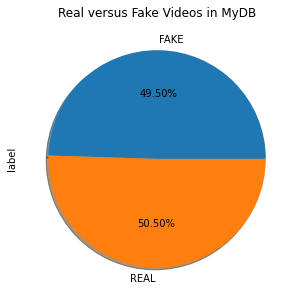

In [ ]:
# Check overall distribution of real and fake videos
meta.groupby('label')['label'].count().plot(figsize=(15, 5), kind='pie', autopct='%1.2f%%', title='Real versus Fake Videos in MyDB', shadow=True)
plt.show()

In [ ]:
# Set path 
base_dir = '/content/drive/MyDrive/DFD/data/MyDB'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training fake faces
train_fake_dir = os.path.join(train_dir, 'Fake')

# Directory with our training real pictures
train_real_dir = os.path.join(train_dir, 'Real')

# Directory with our validation fake pictures
validation_fake_dir = os.path.join(validation_dir, 'Fake')

# Directory with our validation real pictures
validation_real_dir = os.path.join(validation_dir, 'Real')

# Directory with our test fake pictures
test_fake_dir = os.path.join(test_dir, 'Fake')

# Directory with our test real pictures
test_real_dir = os.path.join(test_dir, 'Real')

train_fake_fnames = os.listdir(train_fake_dir)
train_real_fnames = os.listdir(train_real_dir)

In [ ]:
# Print some file names to confirm the right directories are connected 
train_fake_fnames = os.listdir(train_fake_dir)
print(train_fake_fnames[:6])

train_real_fnames = os.listdir(train_real_dir)
train_real_fnames.sort()
print(train_real_fnames[:6])

['df03389.jpg', 'df03464.jpg', 'df03384.jpg', 'df03373.jpg', 'df03453.jpg', 'df03535.jpg']
['abarnvbtwb.mp40.jpgFace.jpg', 'abarnvbtwb.mp4120.jpgFace.jpg', 'abarnvbtwb.mp4144.jpgFace.jpg', 'abarnvbtwb.mp4168.jpgFace.jpg', 'abarnvbtwb.mp4192.jpgFace.jpg', 'abarnvbtwb.mp4216.jpgFace.jpg']


In [ ]:
# Count the number of real and fake images of faces in the train and validation directories
# Check against the figures in metadata file to confirm completeness

# For training, real images are 7,377 and fake images are 7,162.
print('total real images for training:', len(os.listdir(train_real_dir)))
print('total fake images for training:', len(os.listdir(train_fake_dir)))

# For validation, real images are 1,771 and fake images are 1,768.
print('total real images for validation:', len(os.listdir(validation_real_dir)))
print('total fake images for validation:', len(os.listdir(validation_fake_dir)))

total real images for training: 7377
total fake images for training: 7162
total real images for validation: 1771
total fake images for validation: 1768


In [ ]:
BATCH_SIZE = 40
IMG_SIZE = (150, 150)

In [ ]:
train_dataset = tensorflow.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tensorflow.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

test_dataset = tensorflow.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=False,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 14539 files belonging to 2 classes.
Found 3539 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [ ]:
# Define matplotlib parameters for output images as 4x4 images
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 4
ncols = 4

pic_index = 0                               # index for image iteration

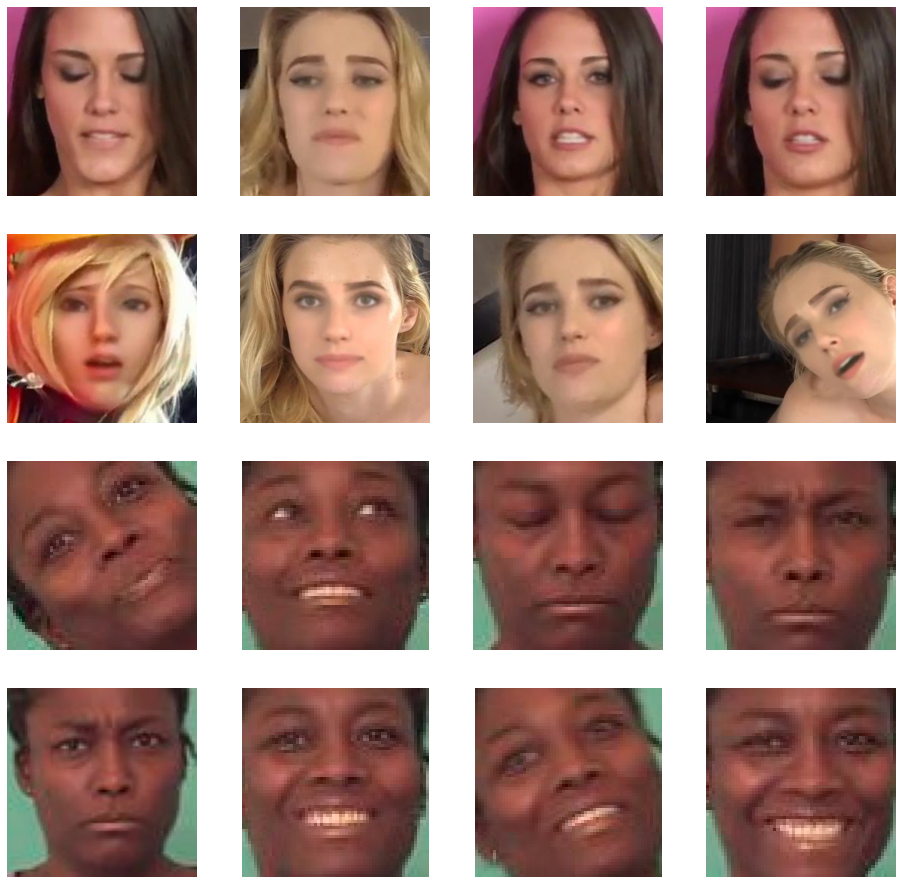

In [ ]:
# Show a batch of 8 real images and 8 fake images - see how difficult for human eyes could distingish real and fake images
# Rerun the cell to fetch a new batch of images 

fig = plt.gcf()                               # set up matplotlib fig
fig.set_size_inches(ncols * 4, nrows * 4)     # size matplotlib fig to fit into a 4x4 image

pic_index += 8
next_real_pix = [os.path.join(train_real_dir, fname) 
                for fname in train_real_fnames[pic_index-8:pic_index]]
next_fake_pix = [os.path.join(train_fake_dir, fname) 
                for fname in train_fake_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_fake_pix+next_real_pix):
  sp = plt.subplot(nrows, ncols, i + 1)       # Set up subplot, subplot indices start at 1
  sp.axis('Off')                              # Turn off axis

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

During review of the images of faces captured in the previous precedures, especially for DFDC preview and celeb-db (v2) datasets, it is noted that the same persons recording the real videos are also used for creating the deepfake. Thus, it introduces more challenges for the model to learn the features to determine if the face is real or fake. 

The following two code snippets show an example of the same persons appears in the DFDC preview real and fake videos.

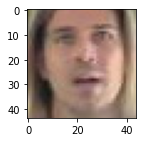

In [ ]:
# Visualise a real face
plt.figure(figsize = (5,2))
viewreal = plt.imread("/content/drive/MyDrive/DFD/data/MyDB/train/Real/aelfnikyqj.mp472.jpgFace.jpg")
plt.imshow(viewreal)

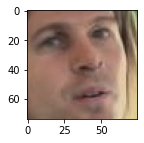

In [ ]:
# Visualise a fake face
plt.figure(figsize = (5,2))
viewfake = plt.imread("/content/drive/MyDrive/DFD/data/MyDB/train/Fake/aagfhgtpmv.mp40.jpgFace.jpg")
plt.imshow(viewfake)

End of notebook